## 2.2.3.15: Enhancing the data assimilation routine within T-Route 

### Author: Tadd Bindas

#### Site of interest: The Old River Control Structure on the Mississippi River, LA

- Perform a simulation in which a time series of streamflow values is substracted from the flow of the Mississippi River and is added to the flow of the Atchafalaya River at the Old River Control Structure
- Demonstrate the aove simulation in a way that the last specified value in the flow time series persists instead of transitioning back to the simulated flow

### Step 0: Read in all of the necessary inputs:
- Old River Control Structure observations: https://waterdata.usgs.gov/monitoring-location/07381482/
- v20.1 Hydrofabric topological data for both the Atchafalaya and the Mississippi
  - Creating a subset for efficient demonstration
- NWM flow inputs
  - Taken from the model retrospective

##### Create v20.1 Hydrofabric domain

Below is the schema for the v20.1 domain to show how the layers of they hydrofabric are connected

<img src="./domain/v201_schema.png" alt="Domain" width="500" height="500">

In [1]:
from pathlib import Path

import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

miss_path = Path.cwd() / "domain/mississippi.gpkg"
atcha_path = Path.cwd() /  "domain/atchafalaya.gpkg"

miss_gdf = gpd.read_file(miss_path, layer="divides")
atcha_gdf = gpd.read_file(atcha_path, layer="divides")

old_river_point = atcha_gdf[atcha_gdf["divide_id"] == "cat-1304933"]


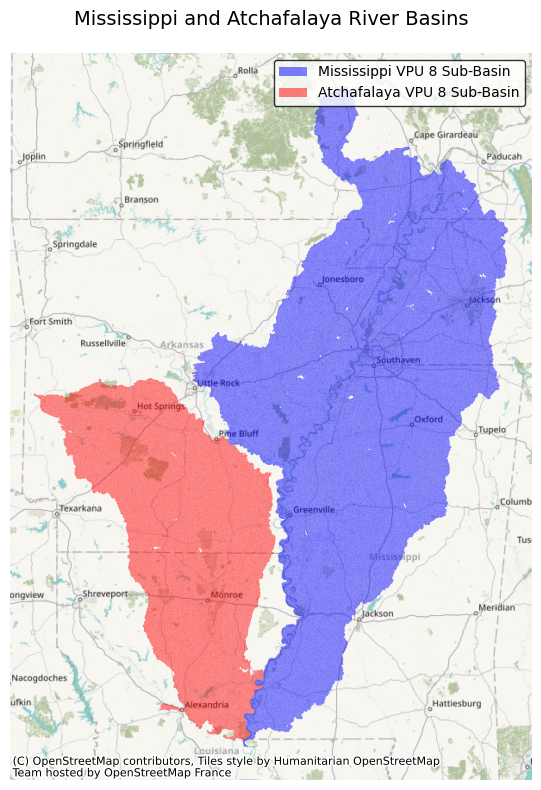

In [2]:
fig, ax = plt.subplots(figsize=(12, 8))
miss_gdf.to_crs(epsg=3857).plot(
    ax=ax,
    alpha=0.5,
    color='blue',
    label='Mississippi Basin'
)
atcha_gdf.to_crs(epsg=3857).plot(
    ax=ax,
    alpha=0.5,
    color='red',
    label='Atchafalaya Basin'
)

cx.add_basemap(ax)

ax.set_title('Mississippi and Atchafalaya River Basins', fontsize=14, pad=20)

legend_elements = [
    Patch(facecolor='blue', alpha=0.5, label='Mississippi VPU 8 Sub-Basin'),
    Patch(facecolor='red', alpha=0.5, label='Atchafalaya VPU 8 Sub-Basin'),
]
ax.legend(
    handles=legend_elements,
    loc='upper right',
    bbox_to_anchor=(1.0, 1.0),
    frameon=True,
    facecolor='white',
    edgecolor='black'
)
    

ax.set_axis_off()
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


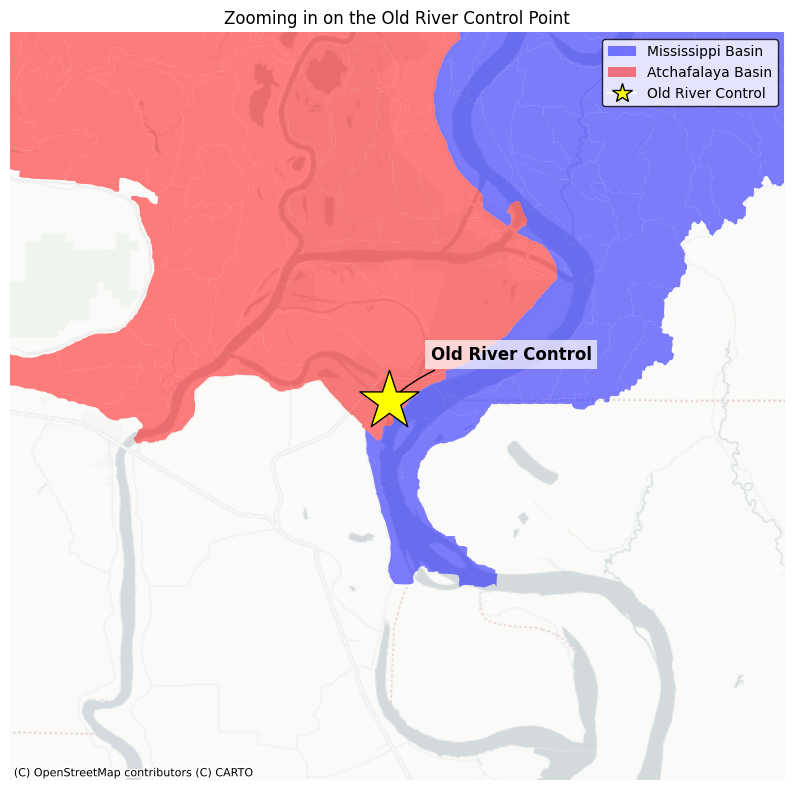

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))

old_river_web = old_river_point.to_crs(3857)

centroid = old_river_web.geometry.centroid.iloc[0]


point_buffer = old_river_web.geometry.buffer(20000).bounds

miss_gdf.to_crs(3857).plot(ax=ax, alpha=0.5, color='blue')
atcha_gdf.to_crs(3857).plot(ax=ax, alpha=0.5, color='red')

ax.scatter(
    centroid.x,
    centroid.y,
    color='yellow',
    marker='*',
    s=2000,
    edgecolor='black',
    zorder=5,
    label='Old River Control'
)
ax.annotate(
    'Old River Control',
    xy=(centroid.x, centroid.y),
    xytext=(30, 30),
    textcoords='offset points',
    fontsize=12,
    fontweight='bold',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2')
)

ax.set_xlim(point_buffer.iloc[0]['minx'], point_buffer.iloc[0]['maxx'])
ax.set_ylim(point_buffer.iloc[0]['miny'], point_buffer.iloc[0]['maxy'])

cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron,
    zoom='auto'
)

legend_elements = [
    Patch(facecolor='blue', alpha=0.5, label='Mississippi Basin'),
    Patch(facecolor='red', alpha=0.5, label='Atchafalaya Basin'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='yellow',
            markeredgecolor='black', markersize=15, label='Old River Control')
]

ax.legend(
    handles=legend_elements,
    loc='upper right',
    bbox_to_anchor=(1.0, 1.0),
    frameon=True,
    facecolor='white',
    edgecolor='black'
)

ax.set_title("Zooming in on the Old River Control Point")

ax.set_axis_off()

ax.set_aspect('equal')

plt.tight_layout()
plt.show()


Now that we can see our domain data is on two different river networks, let's create our T-Route domain file and establish the POI

In [4]:
import pandas as pd

output_path = Path.cwd() /  "domain/merged_domain.gpkg"

layers = [
    "divides",
    "nexus",
    "flowpaths",
    "lakes",
    "flowpath_attributes",
    "network"
]

merged_layers = {}

print(f"Layers in each geopackage: {layers}")

for layer in layers:
    print(f"\nMerging layer: {layer}")
    gdf1 = gpd.read_file(miss_path, layer=layer)
    gdf2 = gpd.read_file(atcha_path, layer=layer)

    if gdf2.crs != gdf1.crs:
        gdf2 = gdf2.to_crs(gdf1.crs)

    merged = pd.concat([gdf1, gdf2], ignore_index=True)
    merged_layers[layer] = merged

    merged.to_file(output_path, layer=layer, driver="GPKG")


Layers in each geopackage: ['divides', 'nexus', 'flowpaths', 'lakes', 'flowpath_attributes', 'network']

Merging layer: divides

Merging layer: nexus

Merging layer: flowpaths

Merging layer: lakes

Merging layer: flowpath_attributes

Merging layer: network


In [5]:
merged_gdf = gpd.read_file(output_path, layer="divides")


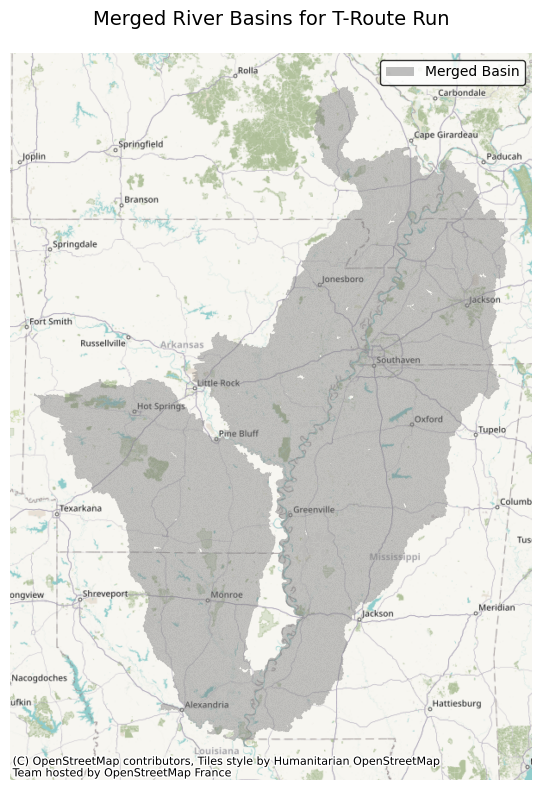

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
merged_gdf.to_crs(epsg=3857).plot(
    ax=ax,
    alpha=0.5,
    color='grey',
    label='Merged Basin'
)

cx.add_basemap(ax)

ax.set_title('Merged River Basins for T-Route Run', fontsize=14, pad=20)

legend_elements = [
    Patch(facecolor='grey', alpha=0.5, label='Merged Basin'),
]
ax.legend(
    handles=legend_elements,
    loc='upper right',
    bbox_to_anchor=(1.0, 1.0),
    frameon=True,
    facecolor='white',
    edgecolor='black'
)
    

ax.set_axis_off()
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


To reduce the file size of the domain data in the T-Route repo, we will be creating a lite version that only will contain flowpaths, lakes, etc, within predefined catchments 

In [7]:
import numpy as np

lite_ids = np.load(Path.cwd() / "domain/lite_ids.npy")


In [8]:
merged_domain_path = Path.cwd() / "domain/merged_domain.gpkg"
output_path = Path.cwd() / "domain/lite_domain.gpkg"

_gdf = gpd.read_file(merged_domain_path, layer="divides")
mask = _gdf["divide_id"].isin([f"cat-{_id}" for _id in lite_ids])
_gdf = _gdf[mask]
_gdf.to_file(output_path, layer="divides", driver="GPKG")

_gdf = gpd.read_file(merged_domain_path, layer="nexus")
mask = _gdf["id"].isin([f"nex-{_id}" for _id in lite_ids])
_gdf = _gdf[mask]
_gdf.to_file(output_path, layer="nexus", driver="GPKG")

_gdf = gpd.read_file(merged_domain_path, layer="flowpaths")
mask = _gdf["id"].isin([f"wb-{_id}" for _id in lite_ids])
_gdf = _gdf[mask]
_gdf.to_file(output_path, layer="flowpaths", driver="GPKG")

_gdf = gpd.read_file(merged_domain_path, layer="flowpath_attributes")
_gdf.to_file(output_path, layer="flowpath_attributes", driver="GPKG")

_gdf = gpd.read_file(merged_domain_path, layer="network")
_gdf.to_file(output_path, layer="network", driver="GPKG")


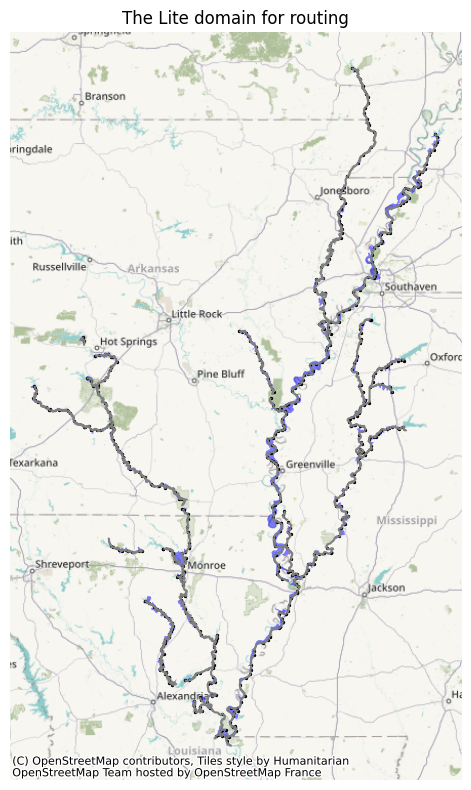

In [9]:
divides = gpd.read_file(output_path, layer="divides").to_crs(3857)
nexus = gpd.read_file(output_path, layer="nexus").to_crs(3857)
flowpaths = gpd.read_file(output_path, layer="flowpaths").to_crs(3857)

fig, ax = plt.subplots(figsize=(12, 8))

divides.plot(ax=ax, alpha=0.5, color='blue')
flowpaths.plot(ax=ax, color='grey')
nexus.plot(ax=ax, color='black', markersize=2)

cx.add_basemap(ax)

ax.set_title("The Lite domain for routing")
ax.set_axis_off()

ax.set_aspect('equal')

plt.tight_layout()
plt.show()


While this plot appears sparse, the underlaying flowpath attributes and network file are intact. By removing unused polygons from the geopackage, we save ~85 MB, and can then attach this output to the T-Route GitHub as it is underneath GitHub's file limit

##### The Old River Control Historical Data

In [10]:
df = pd.read_csv(Path.cwd() / "divergence_obs/old_river_lock.csv")
df


,agency_cd,site_no,datetime,tz_cd,63044_00060,63044_00060_cd,flow_cms
0,USGS,7381482,2023-01-01 00:00:00,CST,77800.0,A,2203.050697
1,USGS,7381482,2023-01-01 00:15:00,CST,78900.0,A,2234.199228
2,USGS,7381482,2023-01-01 00:30:00,CST,76700.0,A,2171.902165
3,USGS,7381482,2023-01-01 00:45:00,CST,78400.0,A,2220.040805
4,USGS,7381482,2023-01-01 01:00:00,CST,77800.0,A,2203.050697
...,...,...,...,...,...,...,...
571,USGS,7381482,2023-01-06 22:45:00,CST,56000.0,A,1585.743432
572,USGS,7381482,2023-01-06 23:00:00,CST,57200.0,A,1619.723648
573,USGS,7381482,2023-01-06 23:15:00,CST,57000.0,A,1614.060279
574,USGS,7381482,2023-01-06 23:30:00,CST,57000.0,A,1614.060279


##### The NWM retrospective data (forcing inputs)

This is taken from TEEHR (https://rtiinternational.github.io/teehr/index.html)

In [11]:
merged_network = gpd.read_file(output_path, layer="network")


In [12]:
atcha_source = "wb-1303762"
mississippi_source = "wb-1313075" 

atcha_comid = merged_network[merged_network["id"] == atcha_source]["hf_id"].values.astype(int)[0]
mississipi_comid = merged_network[merged_network["id"] == mississippi_source]["hf_id"].values.astype(int)[0]
output_comids = [
    atcha_comid,
    mississipi_comid,
]
output_mapping = {
    atcha_comid: 1303762,
    mississipi_comid: 1313075,
}


In [13]:
df = pd.read_parquet(Path.cwd() / "channel_forcing/20230101_20230110.parquet")  # From TEEHR
times = df["value_time"].unique()
pwd = Path.cwd() / "channel_forcing"

for time in times:
    feature_ids = []
    values = []
    data = df[df["value_time"] == time]
    for _, row in data.iterrows():
        _id = int(row["location_id"].split("-")[1])
        feature_ids.append(output_mapping[_id])
        values.append(row["value"])

    converted_time = time.strftime("%Y%m%d%H%M")

    data = {
        'feature_id': feature_ids,
        converted_time: values,
    }

    _df = pd.DataFrame(data)

    _df.to_csv(pwd / f'{converted_time}.CHRTOUT_DOMAIN1.csv', index=False)


### Step 1: Update config entries to reference data

If you look in our config file, we're using the following fields to reference the data:
```yaml
compute_parameters:
    data_assimilation_parameters:
        divergence_outflow : divergence_obs/old_river_lock.csv
```

With an addition to `compute_parameters.py`:
```python
divergence_outflow: Optional[FilePath] = None
"""
CSV file containing DA values for man-made breakages in the hydrofabric (locks). Needs to be obtained and pre-processed from https://waterdata.usgs.gov/monitoring-location/ observations
NOTE: Required for Old River Lock DA (2.2.3.15.2).
"""
```

and a new class in the `DataAssimilation.py` file to follow the patterns within the file
```python
class Divergence(AbstractDA):
    def __init__(self, network, from_files, value_dict):
        LOG.info("divergence class is started.")
        start_time = time.time()
        data_assimilation_parameters = self._data_assimilation_parameters
        run_parameters = self._run_parameters

        self._divergence_df = pd.DataFrame()
        
        if data_assimilation_parameters.get("divergence_outflow", False):
            self._divergence_df = _create_divergence_df(run_parameters, network, data_assimilation_parameters)

        LOG.debug("divergence class is completed in %s seconds." % (time.time() - start_time))
```

### Step 2: Create a Transfer function

See Lines 704-727 of `HyFeaturesNetwork.py`

```python
def diverge_flow(self, data_assimilation, run_set_iterator: int):
    """Divert flow based on man-made structures
    
    Parameters
    ----------
    data_assimilation: DataAssimilation
        The data assimilation object
    run_set_iterator: int
        The timestep that we're working with
    """
    q_lateral = self._qlateral.copy()
    if run_set_iterator >= len(data_assimilation.divergence_df):
        # if there are no more observations, use the last available obs
        run_set_iterator = -1
    divergence_df = data_assimilation.divergence_df.iloc[0]
    diverged_flow = divergence_df["Discharge"]
    inflow_mask = q_lateral.index == divergence_df["inflow"]
    outflow_mask = q_lateral.index == divergence_df["outflow"]

    new_outflow = np.clip(q_lateral[outflow_mask].iloc[0] - diverged_flow, 0, None)
    q_lateral[outflow_mask] = new_outflow
    q_lateral[inflow_mask] += diverged_flow

    self._qlateral = q_lateral   
```

and line 205 of `__main__.py`
```python
if data_assimilation_parameters.get("divergence_outflow", False):   
    network.diverge_flow(data_assimilation, run_set_iterator)
```

### Step 3: Run the Simulation

Let's run the base simulation first

In [14]:
!python -m nwm_routing -f -V4 config_no_transfer.yaml


creating supernetwork connections set
2024-11-15 07:46:38,033 - fiona._env - DEBUG - [env.py:315 - defenv]: GDAL data found in package: path='/home/tadd.bindas/github/pi4/t-route/.venv/lib/python3.10/site-packages/fiona/gdal_data'.
2024-11-15 07:46:38,034 - fiona._env - DEBUG - [env.py:315 - defenv]: PROJ data found in package: path='/home/tadd.bindas/github/pi4/t-route/.venv/lib/python3.10/site-packages/fiona/proj_data'.
supernetwork connections set complete
... in 4.557614326477051 seconds.
2024-11-15 07:46:42,589 - root - INFO - [AbstractNetwork.py:525 - create_independent_networks]: organizing connections into reaches ...
2024-11-15 07:46:42,591 - root - DEBUG - [AbstractNetwork.py:554 - create_independent_networks]: reach organization complete in 0.0017833709716796875 seconds.
2024-11-15 07:46:42,592 - root - INFO - [AbstractNetwork.py:682 - initial_warmstate_preprocess]: setting channel initial states ...
2024-11-15 07:46:42,592 - root - DEBUG - [AbstractNetwork.py:737 - initial_

Next, Let's run the water transfer simulation that points to the observed lock flow

In [15]:
!python -m nwm_routing -f -V4 config.yaml


creating supernetwork connections set
2024-11-15 07:46:56,507 - fiona._env - DEBUG - [env.py:315 - defenv]: GDAL data found in package: path='/home/tadd.bindas/github/pi4/t-route/.venv/lib/python3.10/site-packages/fiona/gdal_data'.
2024-11-15 07:46:56,510 - fiona._env - DEBUG - [env.py:315 - defenv]: PROJ data found in package: path='/home/tadd.bindas/github/pi4/t-route/.venv/lib/python3.10/site-packages/fiona/proj_data'.
supernetwork connections set complete
... in 4.013208389282227 seconds.
2024-11-15 07:47:00,518 - root - INFO - [AbstractNetwork.py:525 - create_independent_networks]: organizing connections into reaches ...
2024-11-15 07:47:00,519 - root - DEBUG - [AbstractNetwork.py:554 - create_independent_networks]: reach organization complete in 0.0011870861053466797 seconds.
2024-11-15 07:47:00,519 - root - INFO - [AbstractNetwork.py:682 - initial_warmstate_preprocess]: setting channel initial states ...
2024-11-15 07:47:00,520 - root - DEBUG - [AbstractNetwork.py:737 - initial_

### Step 4: Evaluate the Output

In [16]:
import xarray as xr

base_paths = list((Path().cwd() / "output").glob("*.nc"))
transfer_paths = list((Path().cwd() / "output_transfer").glob("*.nc"))

datasets = [xr.open_dataset(f, engine="netcdf4") for f in base_paths]
base_flow = xr.concat(datasets, dim="time").sortby('time')

datasets = [xr.open_dataset(f, engine="netcdf4") for f in transfer_paths]
transfer_flow = xr.concat(datasets, dim="time").sortby('time')


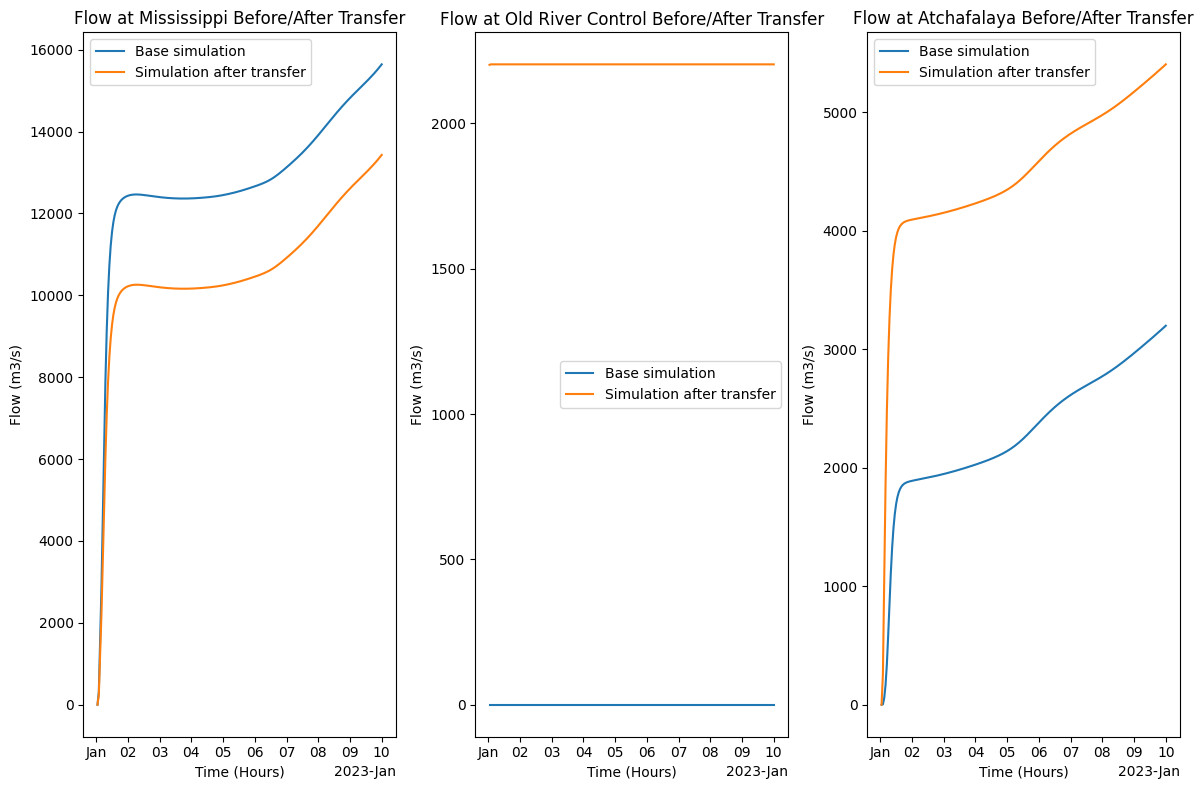

In [17]:
import matplotlib.pyplot as plt

upstream_miss_id = 1313076
transfer_id = 1304933
atcha_id = 1303764

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8))

base_flow.sel(feature_id=upstream_miss_id).flow.plot(ax=ax1, label='Base simulation')
transfer_flow.sel(feature_id=upstream_miss_id).flow.plot(ax=ax1, label='Simulation after transfer')
ax1.set_title('Flow at Mississippi Before/After Transfer')
ax1.set_xlabel('Time (Hours)')
ax1.set_ylabel('Flow (m3/s)')
ax1.legend()

base_flow.sel(feature_id=transfer_id).flow.plot(ax=ax2, label='Base simulation')
transfer_flow.sel(feature_id=transfer_id).flow.plot(ax=ax2, label='Simulation after transfer')
ax2.set_title('Flow at Old River Control Before/After Transfer')
ax2.set_xlabel('Time (Hours)')
ax2.set_ylabel('Flow (m3/s)')
ax2.legend()

base_flow.sel(feature_id=atcha_id).flow.plot(ax=ax3, label='Base simulation')
transfer_flow.sel(feature_id=atcha_id).flow.plot(ax=ax3, label='Simulation after transfer')
ax3.set_title('Flow at Atchafalaya Before/After Transfer')
ax3.set_xlabel('Time (Hours)')
ax3.set_ylabel('Flow (m3/s)')
ax3.legend()

plt.tight_layout()

plt.show()


If you look at the above hydrographs, you can see how the flow is being moved from the Mississippi River into the Atchafalaya River. When this capability will be fully defined with Hydrofabric v2.2, we will use POIs to indicate flow points, and transfer based on the hydrofabric rather than predefined indices. 